In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
import random
import matplotlib.pyplot as plt
import numpy as np

from affinecoupling import AffineCouplingLayer

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

use_cuda = True
pin_memory = False
no_memory_block = False
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(manualSeed)
    pin_memory = True
    no_memory_block = True

%reload_ext autoreload
%autoreload 2

In [2]:
data_root_path = "./data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 4

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Number of training epochs
num_epochs = 5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


In [3]:
transform_cifar10 = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomAffine(0, translate = (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_mnist = transforms.Compose([
    transforms.RandomAffine(0, translate = (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

cifar10_train = torchvision.datasets.CIFAR10(data_root_path, download=True,
                                             train=True, transform=transform_cifar10)
cifar10_test = torchvision.datasets.CIFAR10(data_root_path, download=True,
                                            train=False, transform=transform_cifar10)

trainloader_cifar = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=pin_memory)
testloader_cifar = torch.utils.data.DataLoader(cifar10_test, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, pin_memory=pin_memory)

mnist_train = torchvision.datasets.MNIST(data_root_path, download=True,
                                         train=True, transform=transform_mnist)
mnist_test = torchvision.datasets.MNIST(data_root_path, download=True,
                                        train=False, transform=transform_mnist)

trainloader_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                shuffle=True, num_workers=workers, pin_memory=pin_memory)
testloader_mnist = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=True, num_workers=workers, pin_memory=pin_memory)


Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


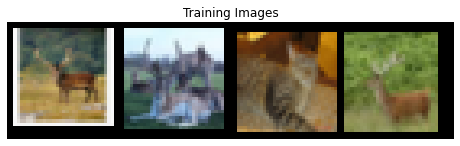

In [4]:
# Check dataset is correct

real_batch = next(iter(trainloader_cifar))
print(real_batch[0].shape)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))